# Named Entity Recognition Model

Will create a named entity recognition model that can extract company names from the emails

</br></br></br>

In [ ]:
!pip install tensorflow-addons==0.23.0
!pip install tf2crf keras_crf
!pip install gdown==4.5.4 --no-cache-dir

In [ ]:
import pandas as pd
import spacy
import spacy.displacy as displacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import nltk
import ast
from collections import Counter
from collections import defaultdict
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split
from tf2crf import CRF, ModelWithCRFLoss
from keras_crf import CRFModel

In [3]:
data = pd.read_csv('NER-Data.csv')

In [ ]:
!gdown "https://drive.google.com/uc?id=1BpfbHu4denceXiv8yfdY3EHgjKIcULku"
embedding_file = './GoogleNews-vectors-negative300.bin.gz'

EDA

In [5]:
data.shape

(47959, 4)

In [6]:
data.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [7]:
data.describe().transpose()

,count,unique,top,freq
Sentence #,47959,47959,Sentence: 1,1
Sentence,47959,47575,VOA 's Mil Arcega reports .,17
POS,47959,47214,"['NNP', 'POS', 'NNP', 'NNP', 'VBZ', '.']",39
Tag,47959,33318,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",450


In [8]:
data.iloc[0]['Tag']

"['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']"

In [9]:
nlp = spacy.load('en_core_web_sm')

for i in range(5):
  displacy.render(nlp(data['Sentence'].iloc[i]), style="ent",
                                                  jupyter=True)
  print("\n\n")

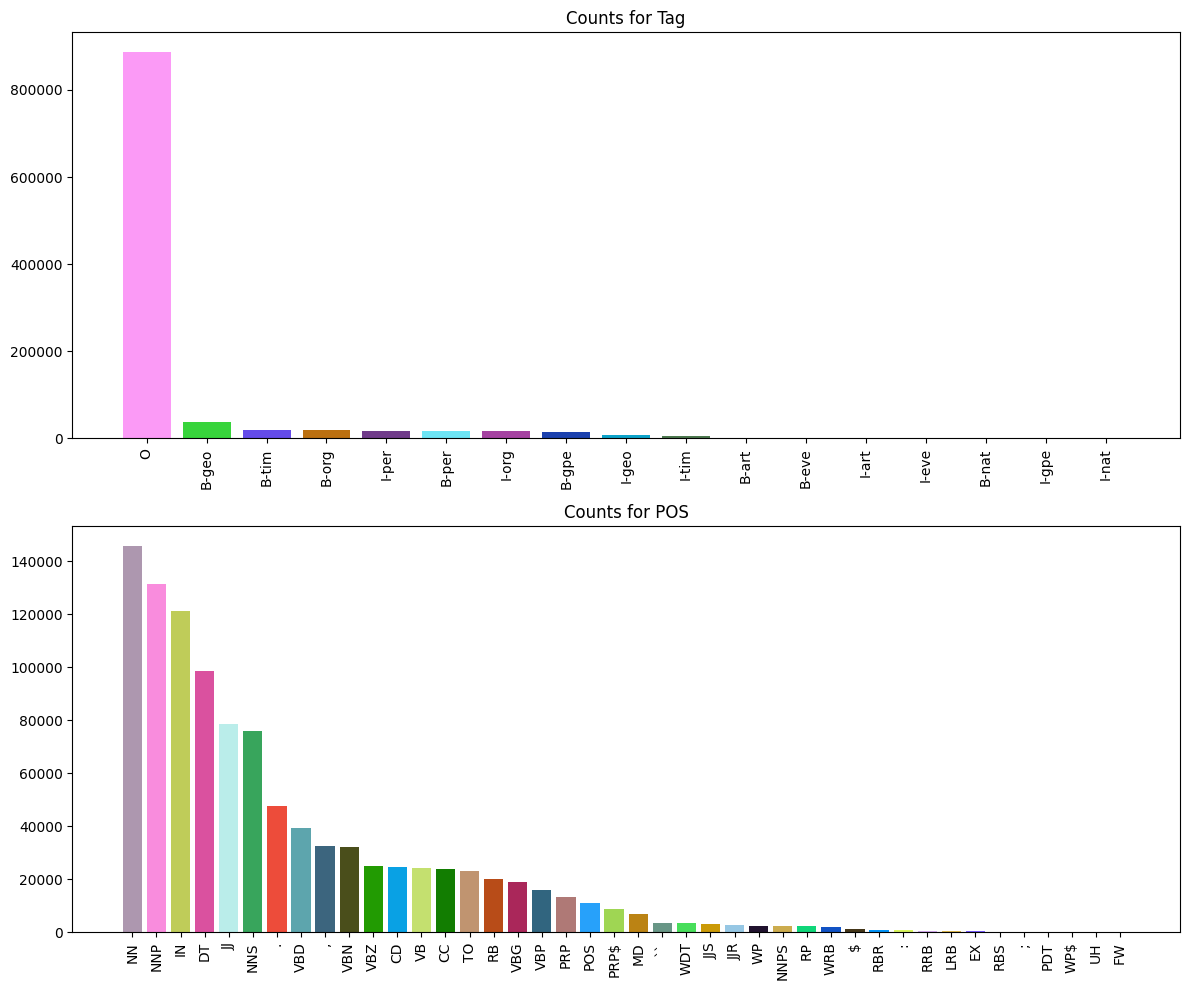

In [10]:
plt.figure(figsize=(12, 10))

def plotCounts(col, i):
  counter = Counter()
  data[col].apply(lambda x : counter.update(ast.literal_eval(x)))

  arr = sorted(zip(list(counter.values()), list(counter.keys())), reverse=True)
  y, x = zip(*arr)

  plt.subplot(2, 1, i)
  plt.bar(x=x, height=y, color=np.random.rand(len(arr), 3))
  plt.xticks(rotation=90, ha='center')
  plt.title("Counts for " + col)
  plt.tight_layout()



plotCounts('Tag', 1)
plotCounts('POS', 2)

In [11]:
"Number of duplicates: " + str(sum(data['Sentence'].duplicated()))

'Number of duplicates: 384'

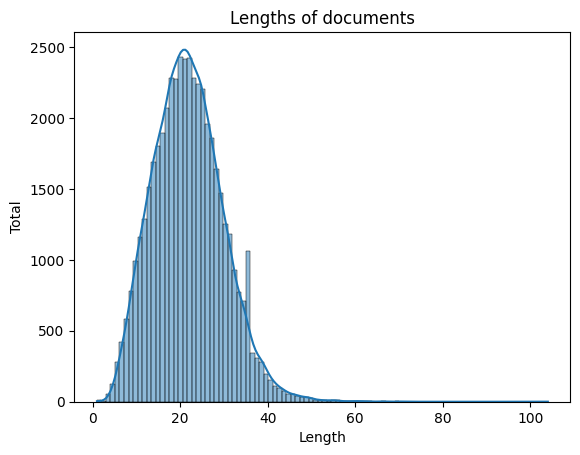

In [12]:
arr = data['Sentence'].apply(lambda x: len(x.split())).values
sns.histplot(arr, bins=100, kde=True)
plt.title("Lengths of documents")
plt.xlabel("Length")
plt.ylabel("Total")
plt.show()

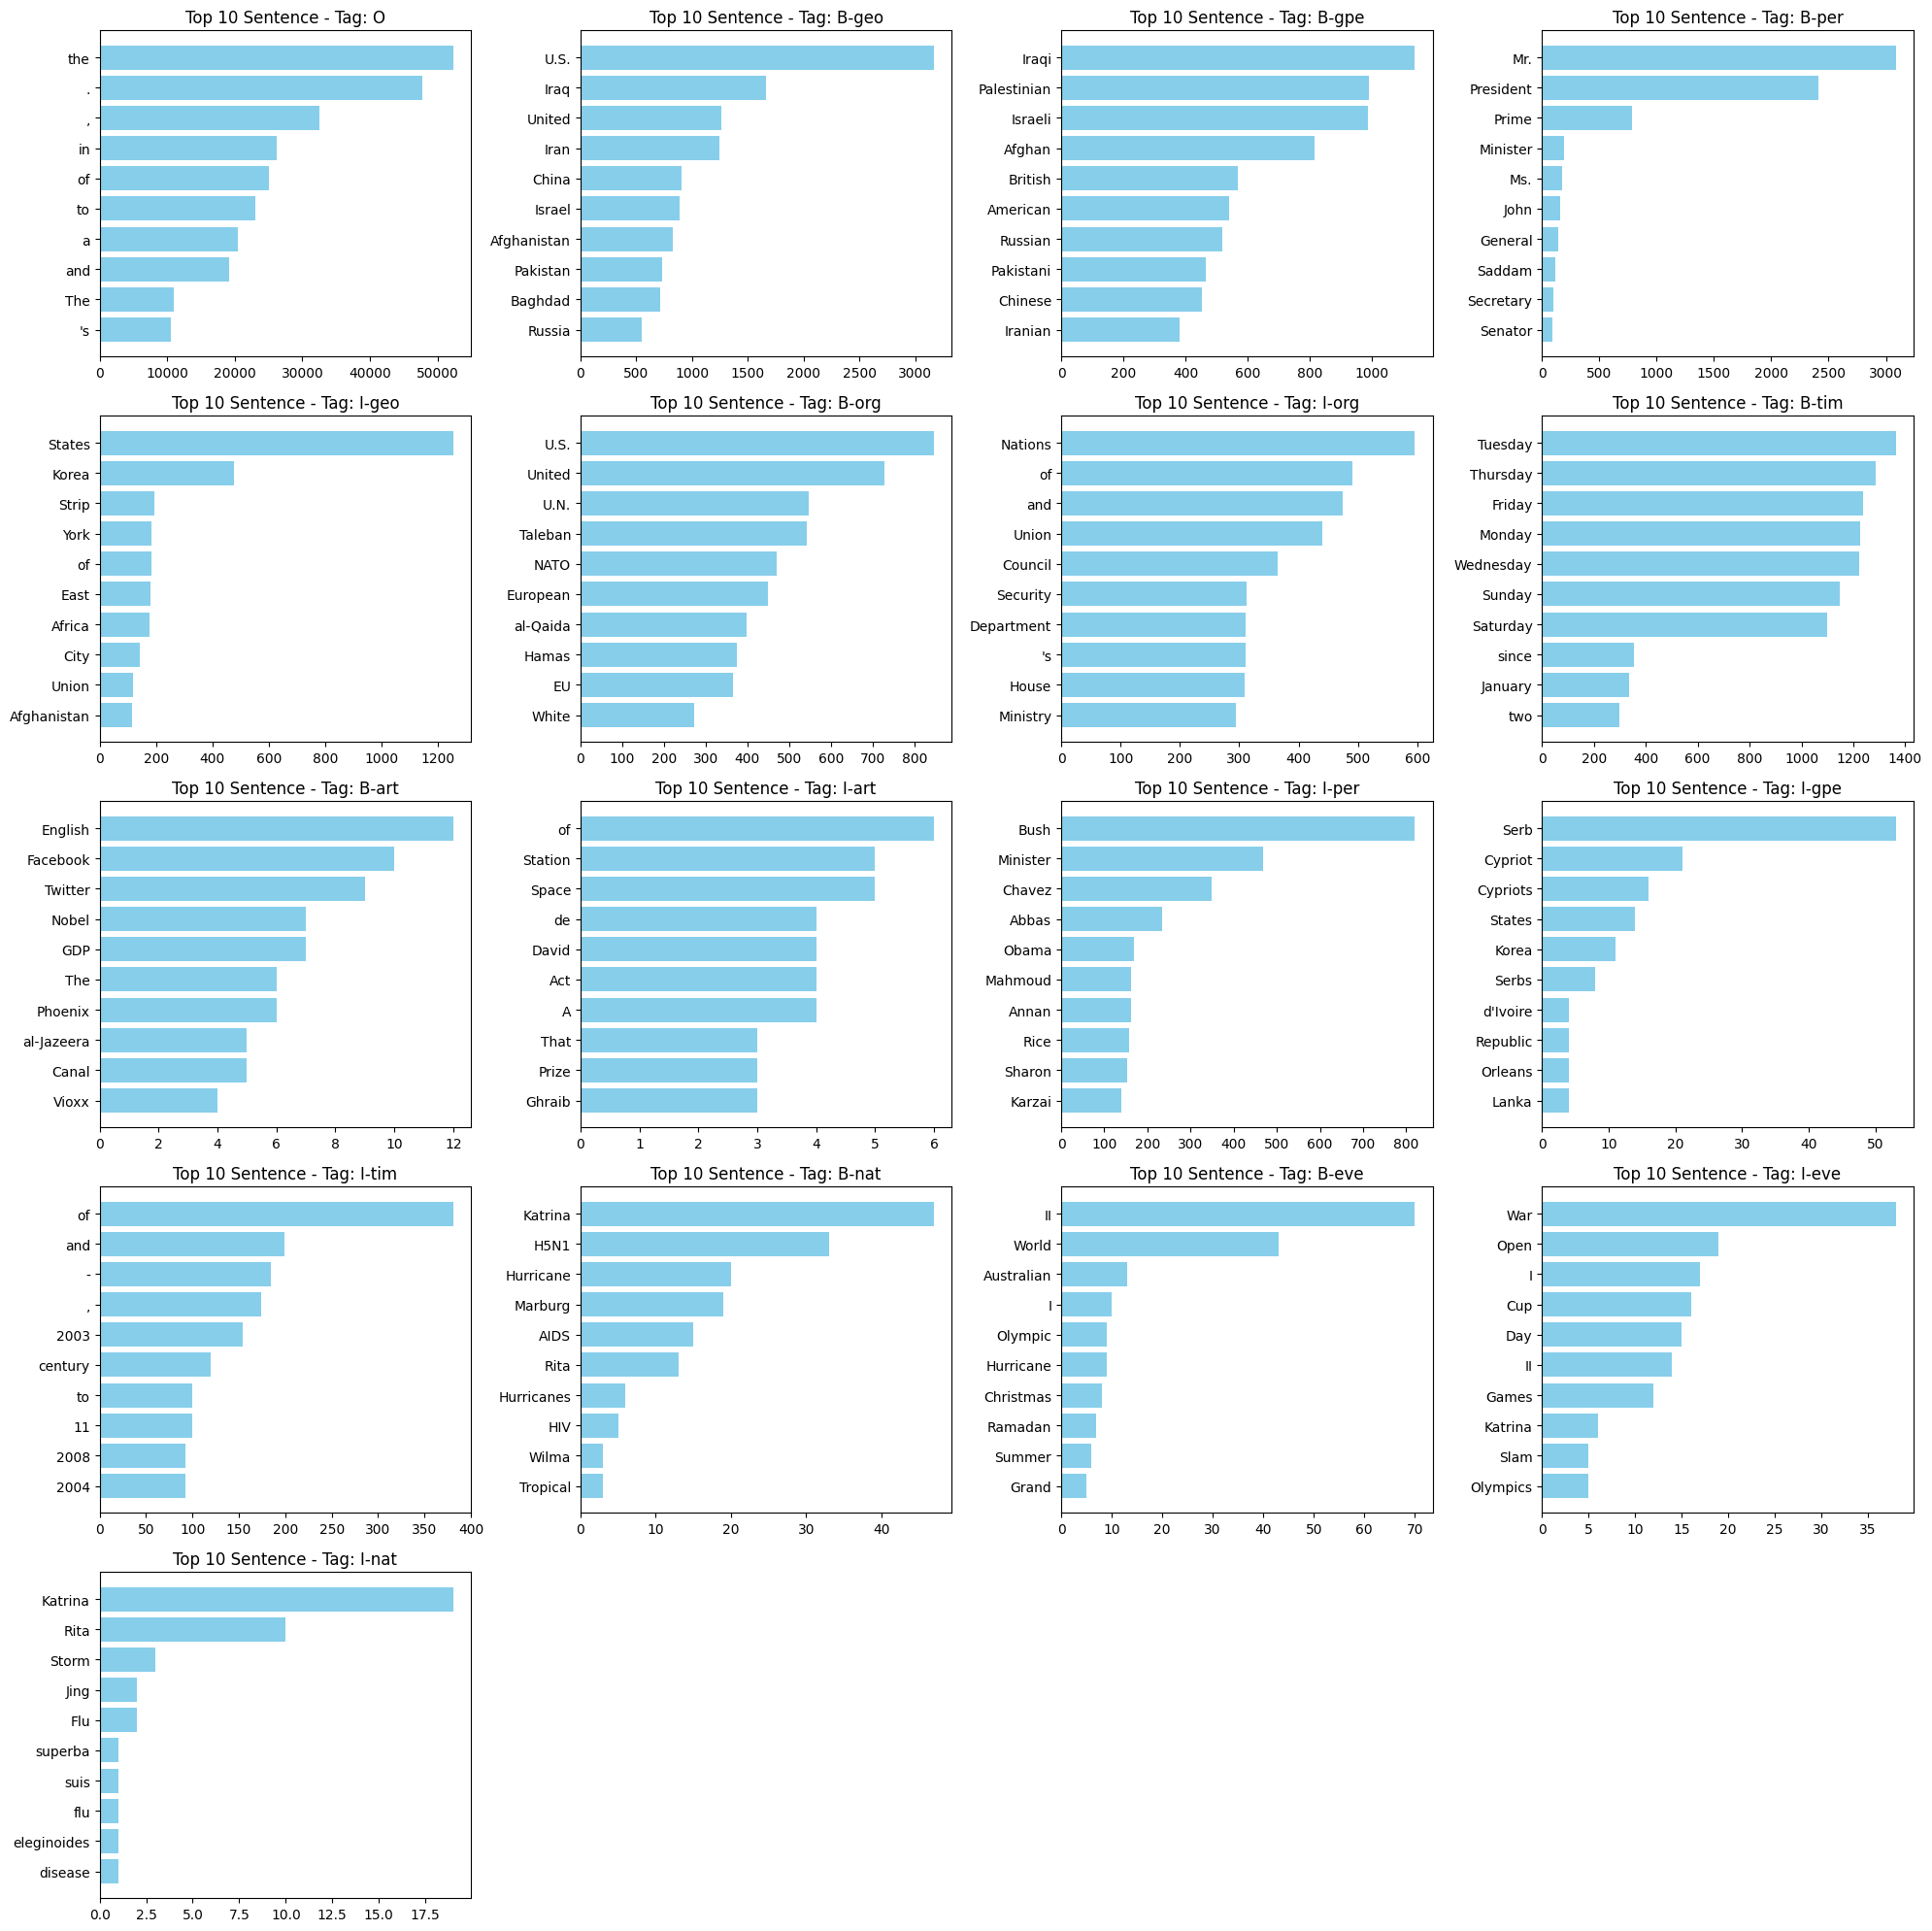

In [13]:
def topThings(col, compareCol, color):
  counter = defaultdict(defaultdict)
  for i in range(len(data)):
    a = list(zip(data.iloc[i][compareCol].split(),
                ast.literal_eval(data.iloc[i][col])))
    for j in a:
      counter[j[1]][j[0]] = 1 if j[0] not in counter[j[1]] else \
                                          counter[j[1]][j[0]] + 1

  a = [sorted([(counter[i][j], i, j) for j in counter[i]],
                            reverse=True) for i in counter]

  plt.figure(figsize=(20, 20))
  c = 1
  for i in a:
    plt.subplot(5, 4, c)
    plt.barh(list(zip(*i))[2][:10][::-1], list(zip(*i))[0][:10][::-1],
                                                          color=color)
    plt.tight_layout()
    plt.title("Top 10 " + compareCol + " - " + col + ": " + i[0][1])
    c += 1

topThings('Tag', 'Sentence', 'skyblue')

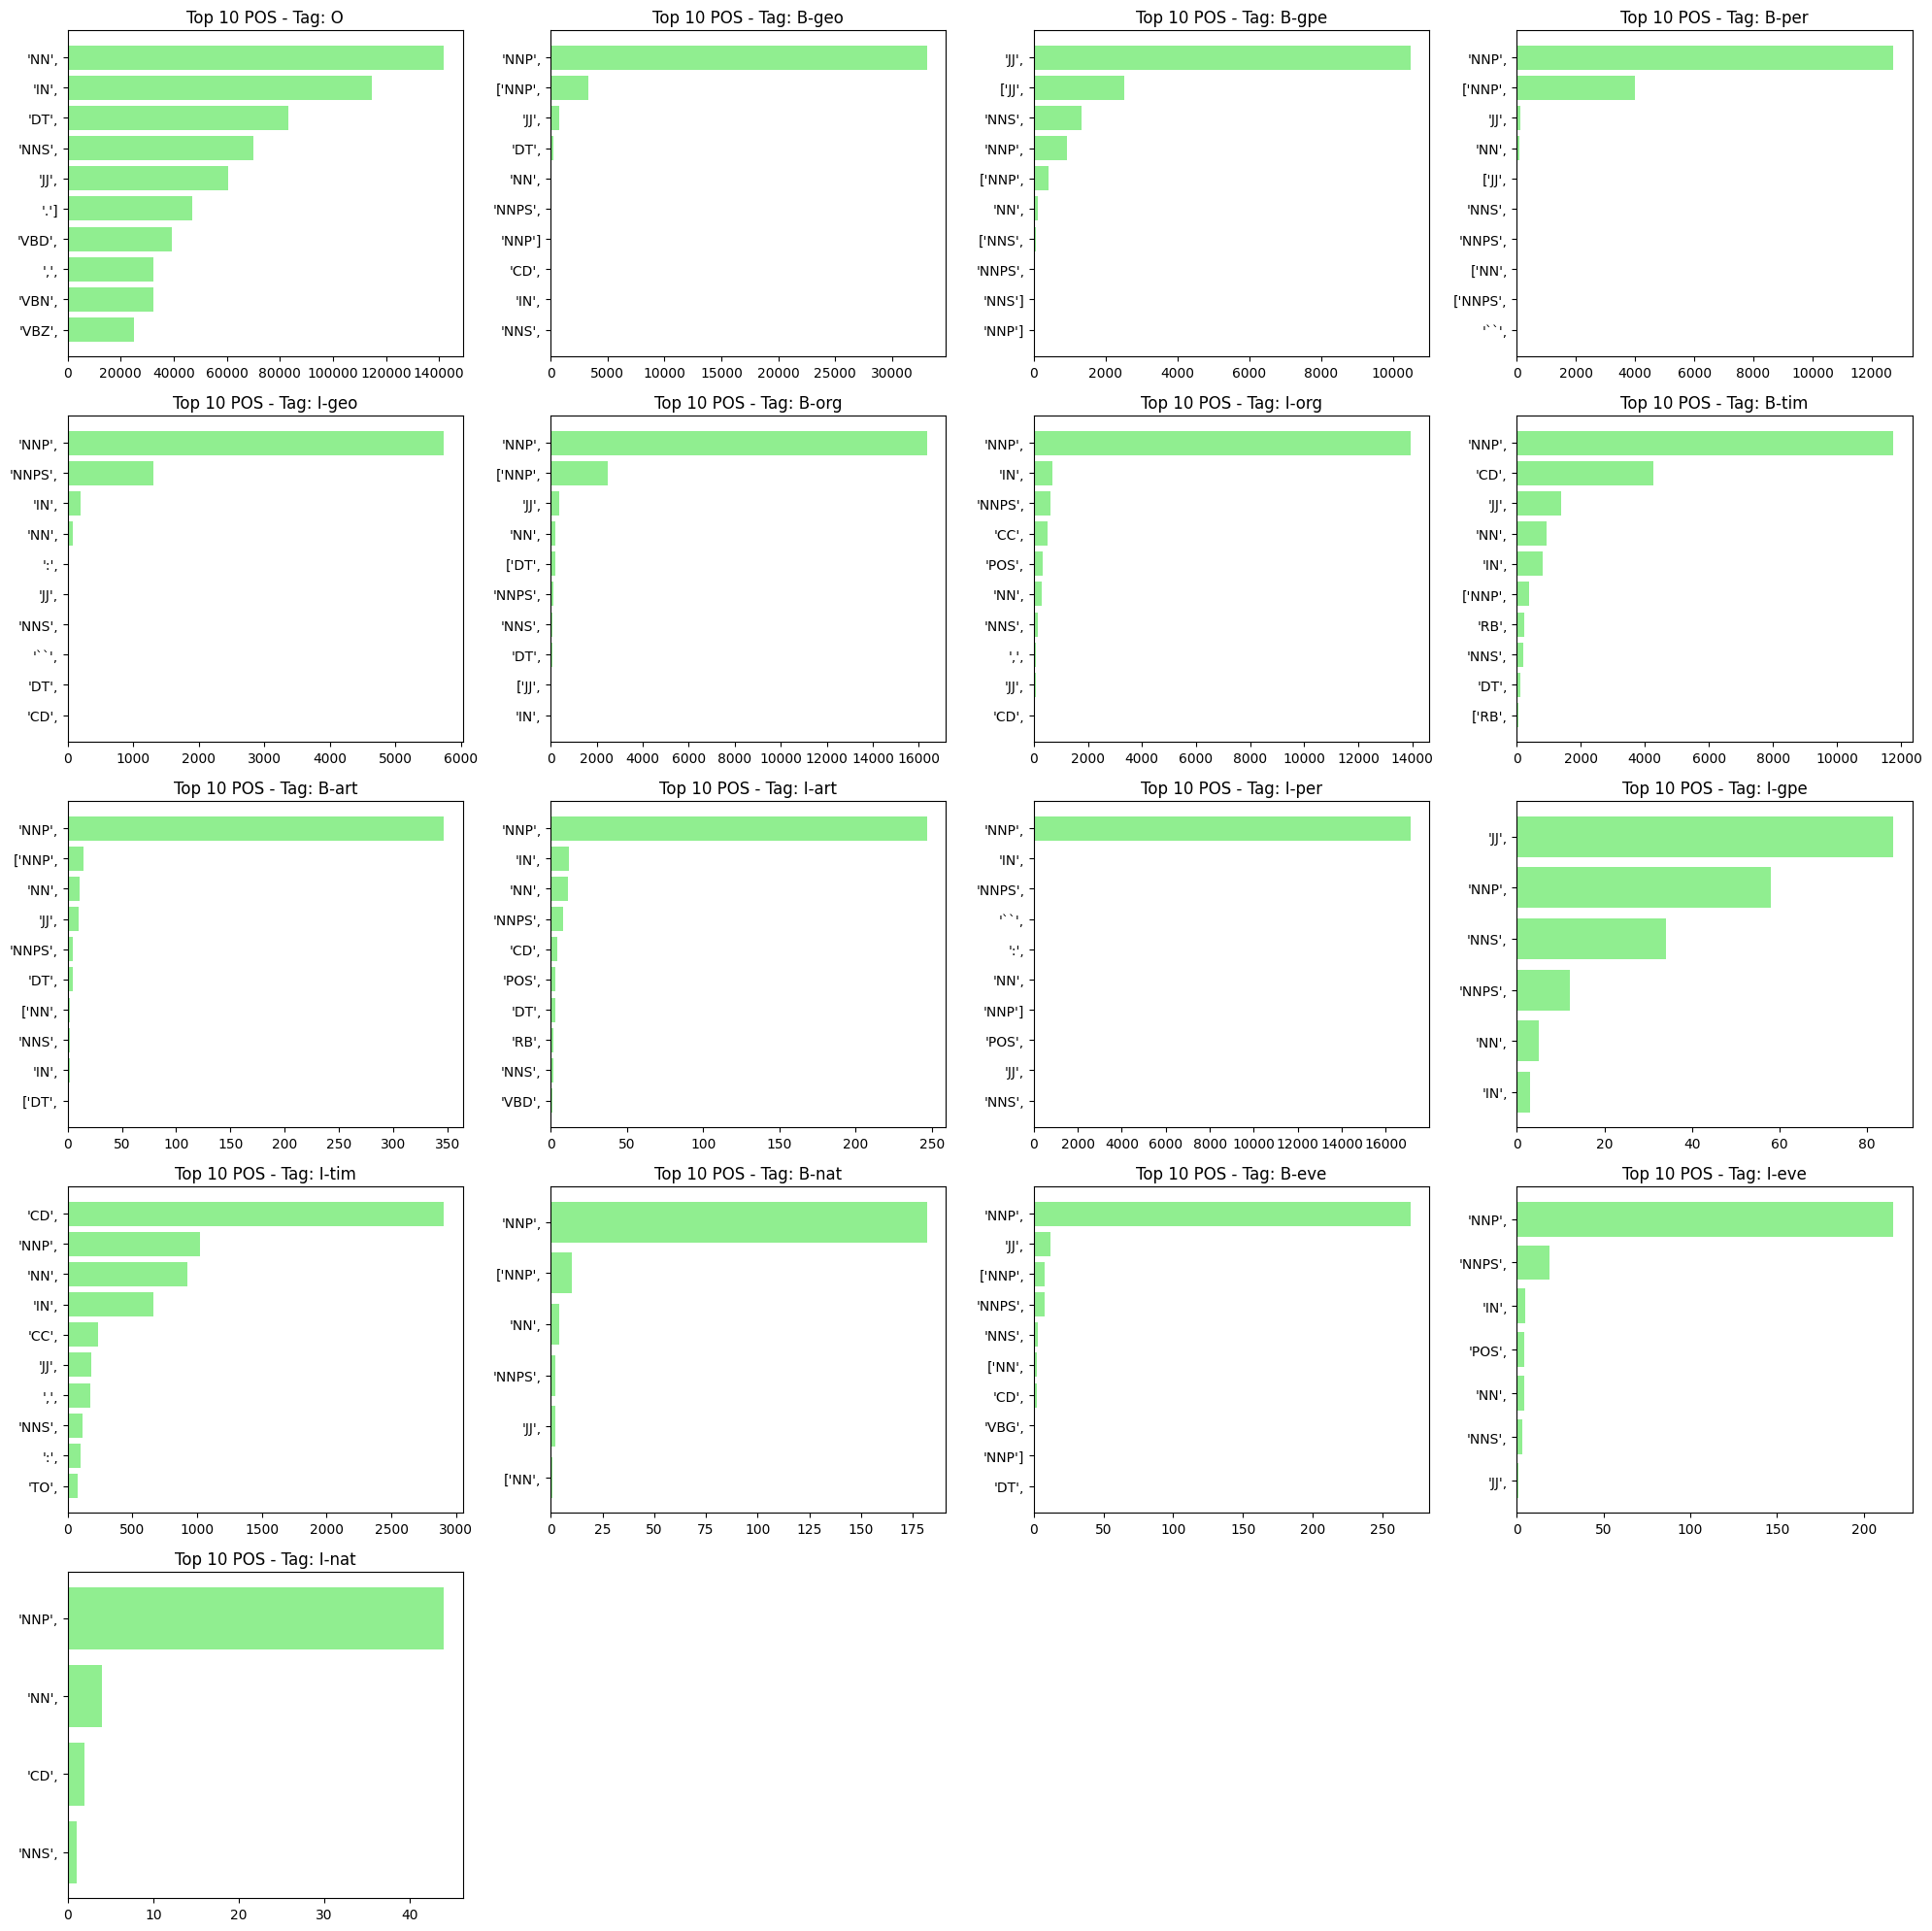

In [14]:
topThings('Tag', 'POS', 'lightgreen')

Preprocessing


In [15]:
data.drop_duplicates(subset=['Sentence'])
data['Sentence'] = data['Sentence'].apply(lambda x : x.split())
data.head(10)

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,"[Families, of, soldiers, killed, in, the, conf...","['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,"[They, marched, from, the, Houses, of, Parliam...","['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"[Police, put, the, number, of, marchers, at, 1...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,"[The, protest, comes, on, the, eve, of, the, a...","['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
5,Sentence: 6,"[The, party, is, divided, over, Britain, 's, p...","['DT', 'NN', 'VBZ', 'VBN', 'IN', 'NNP', 'POS',...","['O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', '..."
6,Sentence: 7,"[The, London, march, came, ahead, of, anti-war...","['DT', 'NNP', 'NN', 'VBD', 'RB', 'IN', 'JJ', '...","['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', '..."
7,Sentence: 8,"[The, International, Atomic, Energy, Agency, i...","['DT', 'NNP', 'NNP', 'NNP', 'NNP', 'VBZ', 'TO'...","['O', 'B-org', 'I-org', 'I-org', 'I-org', 'O',..."
8,Sentence: 9,"[Iran, this, week, restarted, parts, of, the, ...","['NNP', 'DT', 'NN', 'VBD', 'NNS', 'IN', 'DT', ...","['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '..."
9,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","['JJ', 'NNS', 'VBP', 'PRP', 'VBP', 'TO', 'VB',...","['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '..."


In [16]:
X_train, X_test, y_train, y_test = train_test_split(data['Sentence'],
                                                    data['Tag'],
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    train_size=0.8,
                                                    random_state=42)

In [17]:
len(X_train[29649]), len(ast.literal_eval(y_train[29649]))

(25, 25)

In [18]:
y_train = y_train.apply(lambda x : ast.literal_eval(x))
y_val = y_val.apply(lambda x : ast.literal_eval(x))
y_test = y_test.apply(lambda x : ast.literal_eval(x))

In [19]:
sentence_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
sentence_tokenizer.fit_on_texts(X_train)
len(sentence_tokenizer.word_index)

26415

In [20]:
tag_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tag_tokenizer.fit_on_texts(y_train)
len(tag_tokenizer.word_index)

18

In [21]:
X_train = sentence_tokenizer.texts_to_sequences(X_train)
X_val = sentence_tokenizer.texts_to_sequences(X_val)
X_test = sentence_tokenizer.texts_to_sequences(X_test)

y_train = tag_tokenizer.texts_to_sequences(y_train)
y_val = tag_tokenizer.texts_to_sequences(y_val)
y_test = tag_tokenizer.texts_to_sequences(y_test)

In [22]:
word_vectors = KeyedVectors.load_word2vec_format(embedding_file,
                                                    binary=True,
                                                    limit=200000)

embedding_matrix = np.zeros(shape=(len(sentence_tokenizer.word_index),
                                         word_vectors['hi'].shape[0]))

for i, word in enumerate(sentence_tokenizer.word_index):
  if word_vectors.has_index_for(word):
    embedding_matrix[i] = word_vectors[word].copy()

In [23]:
maxlen = 300

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        padding='post',
                                                        maxlen=maxlen)

X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val,
                                                      padding='post',
                                                      maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='post',
                                                       maxlen=maxlen)

y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train,
                                                        padding='post',
                                                        maxlen=maxlen)

y_val = tf.keras.preprocessing.sequence.pad_sequences(y_val,
                                                      padding='post',
                                                      maxlen=maxlen)

y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test,
                                                       padding='post',
                                                       maxlen=maxlen)

In [24]:
X_train.shape, y_train.shape

((30693, 300), (30693, 300))

Model

In [ ]:
inputs = tf.keras.layers.Input(shape=(None,), dtype='int32')

output = tf.keras.layers.Embedding(
          embedding_matrix.shape[0],
          embedding_matrix.shape[1],
          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
          trainable=True,
          input_length=maxlen,
          mask_zero=True)(inputs)

output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128, return_sequences=True, #generates output at each time step
        kernel_initializer=tf.keras.initializers.random_normal(seed=42)))(output)

output = CRF(units=len(tag_tokenizer.word_index) + 1, dtype='float32')(output)

base_model = tf.keras.Model(inputs, output)
model = ModelWithCRFLoss(base_model, sparse_target=True)
model.compile(optimizer='adam', metrics=['acc'])






tf.config.run_functions_eagerly(True)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=3)
history = model.fit(X_train, y_train, epochs=10,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    callbacks=[es_callback])

In [27]:
inputs = tf.keras.layers.Input(shape=(None,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(
          embedding_matrix.shape[0],
          embedding_matrix.shape[1],
          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
          trainable=True,
          input_length=maxlen,
          mask_zero=True)(inputs)

bilstm_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
          128, return_sequences=True, #generates output at each time step
          kernel_initializer=tf.keras.initializers.random_normal(seed=42)
        ))(embedding_layer)

output = CRF(units=len(tag_tokenizer.word_index) + 1, dtype='float32')(bilstm_layer)

BiLSTM_CRF = ModelWithCRFLoss(tf.keras.Model(inputs, output),
                                          sparse_target=True)
BiLSTM_CRF.compile(optimizer='adam')

In [28]:
biGRU_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
          128, return_sequences=True, #generates output at each time step
          kernel_initializer=tf.keras.initializers.random_normal(seed=42)
        ))(embedding_layer)

output = CRF(units=len(tag_tokenizer.word_index) + 1,
                        dtype='float32')(biGRU_layer)

BiGRU_CRF = ModelWithCRFLoss(tf.keras.Model(inputs, output),
                                          sparse_target=True)
BiGRU_CRF.compile(optimizer='adam')

In [ ]:
class RelationLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RelationLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1] * 2, self.units),
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs, **kwargs):
        return tf.square(inputs)

# Create an instance of the custom layer
square_layer = RelationLayer(units=5)

result = square_layer([2.0, 3.0, 4.0])

result

In [29]:
class RelationLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(RelationLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="b", shape=(self.units,), initializer="random_normal", trainable=True,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


Representation_layer = tf.keras.layers.Convolution1D(8, 3)(embedding_layer)
Representation_layer = tf.keras.layers.MaxPooling1D(2)(Representation_layer)
Context_layer_conv_1 = tf.keras.layers.Convolution1D(8, 1)(Representation_layer)
Context_layer_conv_2 = tf.keras.layers.Convolution1D(8, 3)(Context_layer_conv_1)
Context_layer_conv_3 = tf.keras.layers.Convolution1D(8, 5)(Context_layer_conv_2)
Context_layer_act    = tf.keras.layers.Activation('tanh')(Context_layer_conv_3)
Context_layer_pool   = tf.keras.layers.MaxPooling1D(2)(Context_layer_act)
print(Context_layer_pool)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 8), dtype=tf.float32, name=None), name='max_pooling1d_1/Squeeze:0', description="created by layer 'max_pooling1d_1'")


In [ ]:
RelationLayer(5)(np.array([0, 3, 2, 1, 6]))

In [38]:
sequence_input = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='sequence_input')
outputs = tf.keras.layers.Embedding(21128, 128)(sequence_input)
outputs = tf.keras.layers.Dense(256)(outputs)

print(outputs.shape)
base = tf.keras.Model(inputs=sequence_input, outputs=outputs)

# build CRFModel, 5 is num of tags
model = CRFModel(base, 5)

# no need to specify a loss for CRFModel, model will compute crf loss by itself
model.compile(optimizer=tf.keras.optimizers.Adam(3e-4), metrics=['acc'])
model.summary()

(None, None, 256)
Model: "crf_model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence_input (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 embedding_6 (Embedding)     (None, None, 128)            2704384   ['sequence_input[0][0]']      
                                                                                                  
 dense_10 (Dense)            (None, None, 256)            33024     ['embedding_6[0][0]']         
                                                                                                  
 crf_4 (CRF)                 [(None, None),               1320      ['

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=True,
        input_length=maxlen,
        mask_zero=True #following layers ignore padding
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128,
        return_sequences=True, #generates output at each time step
        kernel_initializer=tf.keras.initializers.random_normal(seed=42))
    ),
    tf.keras.layers.Dense(
        len(tag_tokenizer.word_index) + 1,
        activation='softmax',
        kernel_initializer=tf.keras.initializers.random_normal(seed=42)
    ),
    CRFModel(len(tag_tokenizer.word_index) + 1, 200, sparse_target=True)
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                                                  metrics=['accuracy'])

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=True,
        input_length=maxlen,
        mask_zero=True #following layers ignore padding
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128,
        return_sequences=True, #generates output at each time step
        kernel_initializer=tf.keras.initializers.random_normal(seed=42))
    ),
    tf.keras.layers.Dense(
        len(tag_tokenizer.word_index) + 1,
        activation='softmax',
        kernel_initializer=tf.keras.initializers.random_normal(seed=42)
    ),
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                                            metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          7924500   
                                                                 
 bidirectional_2 (Bidirecti  (None, 300, 256)          439296    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 300, 19)           4883      
                                                                 
Total params: 8368679 (31.92 MB)
Trainable params: 8368679 (31.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf.config.run_functions_eagerly(True)



es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=3)

history = model.fit(X_train, y_train, epochs=20,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    callbacks=[es_callback])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


120/120 [==============================] - 13s 105ms/step - loss: 0.8263 - accuracy: 0.8427 - val_loss: 0.4348 - val_accuracy: 0.8891
Epoch 2/20
120/120 [==============================] - 13s 109ms/step - loss: 0.2834 - accuracy: 0.9255 - val_loss: 0.2161 - val_accuracy: 0.9422
Epoch 3/20
120/120 [==============================] - 12s 103ms/step - loss: 0.1567 - accuracy: 0.9555 - val_loss: 0.1779 - val_accuracy: 0.9523
Epoch 4/20
120/120 [==============================] - 14s 117ms/step - loss: 0.1190 - accuracy: 0.9652 - val_loss: 0.1604 - val_accuracy: 0.9558
Epoch 5/20
120/120 [==============================] - 12s 102ms/step - loss: 0.0992 - accuracy: 0.9705 - val_loss: 0.1646 - val_accuracy: 0.9571
Epoch 6/20
120/120 [==============================] - 14s 121ms/step - loss: 0.0866 - accuracy: 0.9739 - val_loss: 0.1602 - val_accuracy: 0.9579
Epoch 7/20
120/120 [==============================] - 12s 104ms/step - loss: 0.0772 - accuracy: 0.9762 - val_loss: 0.1667 - val_accuracy: 0.9

In [ ]:
model.evaluate(X_test, y_test)

300/300 [==============================] - 12s 39ms/step - loss: 0.1706 - accuracy: 0.9554


[0.1705845147371292, 0.9553756713867188]

In [ ]:
s = "Hello - Thank you for your interest in the 286165 Software Engineering Intern – Summer 2024 position at CACI. This requisition has been filled and therefore your application is no longer under consideration for this position. We sincerely appreciate your interest and encourage you to continue to review and apply for other opportunities at CACI by visiting our career site at https://careers.caci.com. Thank you again for your interest in CACI. We wish you the best of luck on your search. Best Regards, CACI Talent Acquisition Team"
s = s.split()
s_len = len(s)
s = sentence_tokenizer.texts_to_sequences([s])
s = tf.keras.preprocessing.sequence.pad_sequences(s, padding='post',
                                                  maxlen=maxlen)[0]

pred = tag_tokenizer.sequences_to_texts([np.argmax(model.predict(np.expand_dims(s, axis=0))[0], axis=1)])[0].split()

1/1 [==============================] - 0s 49ms/step


In [ ]:
s = "Hello - Thank you for your interest in the 286165 Software Engineering Intern – Summer 2024 position at CACI. This requisition has been filled and therefore your application is no longer under consideration for this position. We sincerely appreciate your interest and encourage you to continue to review and apply for other opportunities at CACI by visiting our career site at https://careers.caci.com. Thank you again for your interest in CACI. We wish you the best of luck on your search. Best Regards, CACI Talent Acquisition Team"
s = s.split()

for i in range(len(pred)):
  if pred[i] != 'o':
    if i < len(s):
      print(s[i], i, pred[i])

Summer 15 b-org
2024 16 i-org
